# Autoregressive Model Testing (SARIMA & SARIMAX)

In [200]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import itertools
import warnings
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from IPython.display import display, HTML
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_breusch_godfrey
from statsmodels.api import OLS, add_constant
from scipy.stats import shapiro, anderson
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns

In [177]:
# Load data
df = pd.read_excel('data/Expo Monthly Mastersheet.xlsx')

# Ensure date is datetime and set index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df.index = pd.date_range(start=df.index[0], periods=len(df), freq='MS')
df.columns = df.columns.str.strip()

## Data Preparation

In [218]:
macro_list = ['LFPR', 'CPI', 'r', 'M1', 'GDP', 'IM', 'EX', 'CC']
vol_macro_list = ['vol_LFPR', 'vol_CPI', 'vol_r', 'vol_M1', 'vol_GDP', 'vol_IM', 'vol_EX', 'vol_CC']
asset_list= ['Bitcoin', 'Tether', 'Litecoin', 'XRP', 'Ethereum', 'Dogecoin', 'Cardano', 'USD Coin']
train_end = '2024-01-01'

In [191]:
ar_orders = {}
ar_orders['LFPR'] = {'p': 2, 'd': 0, 'q': 0, 'P': 0, 'D': 0, 'Q': 0, 
                     'Bitcoin_lag': 1, 'Tether_lag': 3, 'Litecoin_lag': 0, 'XRP_lag': 0, 'Ethereum_lag': 0, 'Dogecoin_lag': 0, 
                     'Cardano_lag': 2, 'USD Coin_lag': 0}
ar_orders['CPI'] = {'p': 2, 'd': 2, 'q': 0, 'P': 1, 'D': 1, 'Q': 1, 
                    'Bitcoin_lag': 3, 'Tether_lag': 5, 'Litecoin_lag': 4, 'XRP_lag': 5, 'Ethereum_lag': 0, 'Dogecoin_lag': 6, 
                    'Cardano_lag': 2, 'USD Coin_lag': 2,}
ar_orders['r'] = {'p': 2, 'd': 0, 'q': 0, 'P': 1, 'D': 0, 'Q': 0, 
                  'Bitcoin_lag': 6, 'Tether_lag': 5, 'Litecoin_lag': 5, 'XRP_lag': 3, 'Ethereum_lag': 0, 'Dogecoin_lag': 1, 
                  'Cardano_lag': 2, 'USD Coin_lag': 2}
ar_orders['M1'] = {'p': 1, 'd': 0, 'q': 0, 'P': 1, 'D': 0, 'Q': 1, 
                   'Bitcoin_lag': 1, 'Tether_lag': 2, 'Litecoin_lag': 2, 'XRP_lag': 5, 'Ethereum_lag': 2, 'Dogecoin_lag': 0, 
                   'Cardano_lag': 0, 'USD Coin_lag': 0}
ar_orders['GDP'] = {'p': 2, 'd': 0, 'q': 0, 'P': 1, 'D': 1, 'Q': 0, 
                            'Bitcoin_lag': 0, 'Tether_lag': 2, 'Litecoin_lag': 0, 'XRP_lag': 0, 'Ethereum_lag': 4, 'Dogecoin_lag': 1, 
                            'Cardano_lag': 0, 'USD Coin_lag': 2}
ar_orders['IM'] = {'p': 1, 'd': 0, 'q': 0, 'P': 2, 'D': 1, 'Q': 0, 
                   'Bitcoin_lag': 0, 'Tether_lag': 1, 'Litecoin_lag': 2, 'XRP_lag': 3, 'Ethereum_lag': 3, 'Dogecoin_lag': 0, 
                   'Cardano_lag': 3, 'USD Coin_lag': 1}
ar_orders['EX'] = {'p': 1, 'd': 0, 'q': 0, 'P': 1, 'D': 1, 'Q': 0, 
                   'Bitcoin_lag': 4, 'Tether_lag': 0, 'Litecoin_lag': 0, 'XRP_lag': 0, 'Ethereum_lag': 0, 'Dogecoin_lag': 0, 
                   'Cardano_lag': 0, 'USD Coin_lag': 6}
ar_orders['CC'] = {'p': 2, 'd': 0, 'q': 0, 'P': 1, 'D': 1, 'Q': 1, 
                   'Bitcoin_lag': 0, 'Tether_lag': 0, 'Litecoin_lag': 0, 'XRP_lag': 4, 'Ethereum_lag': 0, 'Dogecoin_lag': 3, 
                   'Cardano_lag': 0, 'USD Coin_lag': 4}
# ar_orders['PC1_macro'] = {'p': 1, 'd': 1, 'q': 0, 'P': 1, 'D': 1, 'Q': 0, 
#                           'Bitcoin_lag': 2, 'Tether_lag': 0, 'Litecoin_lag': 2, 'XRP_lag': 4, 'Ethereum_lag': 1, 'Dogecoin_lag': 4, 
#                           'Cardano_lag': 1, 'USD Coin_lag': 4, 'PC1_crypto_lag': 1, 'PC2_crypto_lag': 1, 'VIX_lag': 0}
# ar_orders['PC2_macro'] = {'p': 1, 'd': 1, 'q': 1, 'P': 1, 'D': 1, 'Q': 0, 
#                           'Bitcoin_lag': 0, 'Tether_lag': 0, 'Litecoin_lag': 0, 'XRP_lag': 0, 'Ethereum_lag': 0, 'Dogecoin_lag': 1, 
#                           'Cardano_lag': 1, 'USD Coin_lag': 2, 'PC1_crypto_lag': 0, 'PC2_crypto_lag': 0, 'VIX_lag': 0}

# ar_orders['CC 
# 
#  % Change'] = {'p': 2, 'd': 0,'q': 0, 'P': 2, 'D': 1, 'Q': 0}
# ar_orders['VIX'] = {'p': 1, 'd': 0,'q': 0, 'P': 1, 'D': 1, 'Q': 0}
# ar_orders['MOVE'] = {'p': 1, 'd': 1,'q': 0, 'P': 1, 'D': 0, 'Q': 0}
# ar_orders['vol_LFPR'] = {'p': 1, 'd': 1,'q': 0}
# ar_orders['vol_CPI'] = {'p': 1, 'd': 1, 'q': 0}
# ar_orders['vol_r'] = {'p': 1, 'd': 1,'q': 0}
# ar_orders['vol_M1'] = {'p': 1, 'd': 1,'q': 0}
# ar_orders['vol_GDP'] = {'p': 1, 'd': 1, 'q': 0}
# ar_orders['vol_IM'] = {'p': 1, 'd': 2,'q': 0}
# ar_orders['vol_EX'] = {'p': 1, 'd': 1, 'q': 0}
# ar_orders['vol_CC'] = {'p': 1, 'd': 1,'q': 0}

## Checking Variable Stationarity, ACF, PACF

In [180]:
def check_stationarity(series):
    result = adfuller(series.dropna())
    p_value = result[1]
    print(f"ADF test for {series.name}: p-value = {p_value:.4f}")

In [181]:
# ACF and PACF
def acf(series, name = 'variable'):
    fig, ax = plt.subplots(2, 1, figsize=(10, 6))
    plot_acf(series, lags=30, ax=ax[0])
    ax[0].set_title(f'ACF of {name}')
    plot_pacf(series, lags=30, ax=ax[1])
    ax[1].set_title(f'PACF of {name}')
    plt.tight_layout()
    plt.show()

In [193]:
# variable = 'CC'
# check_stationarity(df[variable])
# series = df[variable].dropna()
# acf(series, variable)
# df[f'{variable}_diff'] = df[variable].diff()
# series = df[f'{variable}_diff'].dropna()
# acf(series, f'{variable}_diff')
# check_stationarity(df[f'{variable}_diff'])

# df[f'{variable}_diff_diff'] = df[f'{variable}_diff'].diff()
# series = df[f'{variable}_diff_diff'].dropna()
# acf(series, f'{variable}_diff_diff')
# check_stationarity(df[f'{variable}_diff_diff'])

## SARIMA(X) Model

In [171]:
from itertools import product
P = Q = range(0, 3)
D = [0, 1]
s = 12  # for monthly data

# All combinations of parameters

seasonal_combinations = list(product(P, D, Q))

In [173]:
def find_best_seasonal_order(y, macro, ar_orders, exog=None, seasonal_period=12, verbose=False):
    best_aic = np.inf
    best_model = None
    best_seasonal_order = None

    # Fixed p, d, q
    order = (
        ar_orders[macro]['p'],
        ar_orders[macro]['d'],
        ar_orders[macro]['q']
    )

    for P, D, Q in seasonal_combinations:
        seasonal_order = (P, D, Q, seasonal_period)

        try:
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore")
                model = SARIMAX(
                    y,
                    exog=exog,
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
                results = model.fit(disp=False)

                if results.aic < best_aic:
                    best_aic = results.aic
                    best_model = results
                    best_seasonal_order = seasonal_order

                if verbose:
                    print(f"Tried SARIMA{order}x{seasonal_order} AIC={results.aic:.2f}")

        except Exception as e:
            if verbose:
                print(f"Failed SARIMA{order}x{seasonal_order}: {e}")
            continue

    return order, best_seasonal_order, best_model

In [174]:
macro = "LFPR"
y = df[macro].dropna()

order, best_seasonal_order, best_model = find_best_seasonal_order(y, macro, ar_orders, seasonal_period=12, verbose=True)

print("Fixed order:", order)
print("Best seasonal order:", best_seasonal_order)
print("Best AIC:", best_model.aic)

Tried SARIMA(2, 0, 0)x(0, 0, 0, 12) AIC=-666.41
Tried SARIMA(2, 0, 0)x(0, 0, 1, 12) AIC=-571.24
Tried SARIMA(2, 0, 0)x(0, 0, 2, 12) AIC=2537.70
Tried SARIMA(2, 0, 0)x(0, 1, 0, 12) AIC=-515.16
Tried SARIMA(2, 0, 0)x(0, 1, 1, 12) AIC=-462.11
Tried SARIMA(2, 0, 0)x(0, 1, 2, 12) AIC=2585.32
Tried SARIMA(2, 0, 0)x(1, 0, 0, 12) AIC=-563.35
Tried SARIMA(2, 0, 0)x(1, 0, 1, 12) AIC=-561.27
Tried SARIMA(2, 0, 0)x(1, 0, 2, 12) AIC=2690.79
Tried SARIMA(2, 0, 0)x(1, 1, 0, 12) AIC=-436.71
Tried SARIMA(2, 0, 0)x(1, 1, 1, 12) AIC=-451.58
Tried SARIMA(2, 0, 0)x(1, 1, 2, 12) AIC=-425.25
Tried SARIMA(2, 0, 0)x(2, 0, 0, 12) AIC=-459.80
Tried SARIMA(2, 0, 0)x(2, 0, 1, 12) AIC=-459.76
Tried SARIMA(2, 0, 0)x(2, 0, 2, 12) AIC=2696.45
Tried SARIMA(2, 0, 0)x(2, 1, 0, 12) AIC=-403.23
Tried SARIMA(2, 0, 0)x(2, 1, 1, 12) AIC=-419.64
Tried SARIMA(2, 0, 0)x(2, 1, 2, 12) AIC=-417.30
Fixed order: (2, 0, 0)
Best seasonal order: (0, 0, 0, 12)
Best AIC: -666.4136103194911


In [147]:
def check_model_assumptions_arx(y_train, X_train, model_residuals):
    # Add constant to X
    X_const = add_constant(X_train)
    
    # 1. Breusch–Pagan test for heteroskedasticity
    ols_model = OLS(y_train, X_const).fit()
    bp_stat, bp_pvalue, _, _ = het_breuschpagan(ols_model.resid, X_const)

    # 3. Breusch–Godfrey test
    bg_stat, bg_pvalue, _, _ = acorr_breusch_godfrey(ols_model, nlags=1)

    # 4. Shapiro-Wilk test for normality
    shapiro_stat, shapiro_p = shapiro(model_residuals)

    # 5. Anderson-Darling test
    ad_result = anderson(model_residuals)
    ad_stat = ad_result.statistic
    ad_crit = list(zip(ad_result.significance_level, ad_result.critical_values))

    # 6. Mean of residuals
    mean_resid = model_residuals.mean()

    return {
        "Breusch-Pagan p": bp_pvalue,
        "Breusch-Godfrey p": bg_pvalue,
        "Shapiro p": shapiro_p,
        "Anderson stat": ad_stat,
        "Anderson crit": ad_crit,
        "Mean resid": mean_resid,
    }

In [222]:
def run_model(df, macro, asset, plot=False):
    order_dict = ar_orders.get(macro, {'p': 1, 'd': 1, 'q': 0, 'P': 1, 'D': 1, 'Q': 0})
    
    # Unpack ARIMA and seasonal orders
    p = order_dict['p']
    d = order_dict['d']
    q = order_dict['q']
    P = order_dict['P']
    D = order_dict['D']
    Q = order_dict['Q']

    # Extract asset-specific lag
    asset_lag_key = f"{asset}_lag"
    asset_lag = order_dict.get(asset_lag_key, 0)
    asset_lag = 0

    ### ==== AR Data: Use only macro series ==== ###
    df_macro = df[[macro]].dropna().copy()
    target_ar = df_macro[macro]
    train_endog_ar = target_ar[:train_end]
    test_endog_ar = target_ar[train_end:]

    ### ==== ARX Data: Use macro + asset ==== ###
    df_temp = df[[macro, asset]].dropna().copy()

    # Create lagged asset columns
    for lag in range(1, asset_lag + 1):
        df_temp[f'{asset}_lag{lag}'] = df_temp[asset].shift(lag)

    exog_cols = [asset] + [f'{asset}_lag{lag}' for lag in range(1, asset_lag + 1)]
    df_temp = df_temp.dropna()

    exog = df_temp[exog_cols]
    target_arx = df_temp[macro]

    train_endog_arx = target_arx[:train_end]
    train_exog = exog[:train_end]
    test_endog_arx = target_arx[train_end:]
    test_exog = exog[train_end:]

    ### ==== Fit AR and ARX Models ==== ###
    with warnings.catch_warnings(record=True) as w:
        warnings.simplefilter("always", ConvergenceWarning)
        ar_model = SARIMAX(train_endog_ar, order=(p, d, q), seasonal_order=(1, 1, 0, 12))
        ar_result = ar_model.fit(disp=False)
        arx_model = SARIMAX(train_endog_arx, exog=train_exog, order=(p, d, q), seasonal_order=(1, 1, 0, 12))
        arx_result = arx_model.fit(disp=False)

        for warning in w:
            if issubclass(warning.category, ConvergenceWarning):
                print(f"[WARNING] Convergence issue in macro: {macro}, asset: {asset}")

    ### ==== Forecasts ==== ###
    pred_ar = ar_result.get_forecast(steps=len(test_endog_ar)).predicted_mean
    conf_int_ar = ar_result.get_forecast(steps=len(test_endog_ar)).conf_int()

    pred_arx = arx_result.get_forecast(steps=len(test_endog_arx), exog=test_exog).predicted_mean
    conf_int_arx = arx_result.get_forecast(steps=len(test_endog_arx), exog=test_exog).conf_int()

    # Align index for plotting
    pred_ar.index = test_endog_ar.index
    pred_arx.index = test_endog_arx.index
    conf_int_ar.index = test_endog_ar.index
    conf_int_arx.index = test_endog_arx.index

    ### ==== Plotting ==== ###
    if plot:
        plt.figure(figsize=(10, 5))
        plt.plot(train_endog_ar, label='Training Actual', color='black')
        plt.plot(ar_result.fittedvalues, label='AR Fitted', linestyle='--', color='blue')
        plt.plot(arx_result.fittedvalues, label='ARX Fitted', linestyle='--', color='red')
        plt.title(f"In-Sample Fitted Values: {macro}")
        plt.xlabel("Date")
        plt.ylabel(macro)
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(10, 5))
        plt.plot(target_ar, label='Actual ' + macro, color='black')
        plt.plot(pred_ar, label=f'Forecasted {macro} (AR only)', linestyle='--', color='blue')
        plt.fill_between(pred_ar.index, conf_int_ar.iloc[:, 0], conf_int_ar.iloc[:, 1], color='blue', alpha=0.1)
        plt.plot(pred_arx, label=f'Forecasted {macro} (ARX with {asset})', linestyle='--', color='red')
        plt.fill_between(pred_arx.index, conf_int_arx.iloc[:, 0], conf_int_arx.iloc[:, 1], color='red', alpha=0.1)
        plt.title("Out-of-Sample Forecast")
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(10, 5))
        plt.plot(test_endog_ar, label='Actual ' + macro, marker='o', color='black')
        plt.plot(pred_ar, label=f'AR Forecast', linestyle='--', marker='x', color='blue')
        plt.plot(pred_arx, label=f'ARX Forecast', linestyle='--', marker='s', color='red')
        plt.title("Forecast vs Actual (Test Period)")
        plt.xlabel("Date")
        plt.ylabel(macro)
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8, 4))
        sns.histplot(arx_result.resid, kde=True, bins=30, color='skyblue')
        plt.title("Residuals Histogram with KDE")
        plt.xlabel("Residual")
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()
        residuals = arx_result.resid
        # Combine into a DataFrame
        resid_df = residuals.to_frame(name='Residual')
        resid_df.index.name = 'Month'  # Optional: label the index

        # Print the first few rows
        print(resid_df)

    ### ==== Metrics ==== ###
    metrics = [
        {
            'Model': 'AR',
            'MAE': mean_absolute_error(test_endog_ar, pred_ar),
            'RMSE': np.sqrt(mean_squared_error(test_endog_ar, pred_ar)),
            'R2': r2_score(test_endog_ar, pred_ar),
            'MAPE (%)': mean_absolute_percentage_error(test_endog_ar, pred_ar) * 100,
            'Order': f'({p},{d},{q})'
        },
        {
            'Model': 'ARX',
            'MAE': mean_absolute_error(test_endog_arx, pred_arx),
            'RMSE': np.sqrt(mean_squared_error(test_endog_arx, pred_arx)),
            'R2': r2_score(test_endog_arx, pred_arx),
            'MAPE (%)': mean_absolute_percentage_error(test_endog_arx, pred_arx) * 100,
            'Order': f'({p},{d},{q})'
        }
    ]
    assumptions = check_model_assumptions_arx(train_endog_arx, train_exog, arx_result.resid)
    return pd.DataFrame(metrics).set_index('Model'), assumptions


In [223]:
all_assumptions = []

for macro in ar_orders.keys():
    for asset in df.columns:
        if asset == macro:
            continue
        try:
            metrics, assumptions = run_model(df, macro, asset, plot=False)
            result_row = {
                "Macro": macro,
                "Asset": asset,
                "Breusch-Pagan p": assumptions["Breusch-Pagan p"],
                "Breusch-Godfrey p": assumptions["Breusch-Godfrey p"],
                "Shapiro p": assumptions["Shapiro p"],
                "Anderson stat": assumptions["Anderson stat"],
                "Mean resid": assumptions["Mean resid"],
            }

            # Optionally flatten Anderson critical values at 5% level
            for level, crit_val in assumptions["Anderson crit"]:
                if level == 5:
                    result_row["Anderson 5% crit"] = crit_val

            all_assumptions.append(result_row)

        except Exception as e:
            print(f"Failed for Macro: {macro}, Asset: {asset} — {e}")
assumptions_df = pd.DataFrame(all_assumptions)


[WARNING] Convergence issue in macro: LFPR, asset: Cardano
[WARNING] Convergence issue in macro: LFPR, asset: r_diff
[WARNING] Convergence issue in macro: CPI, asset: VIX
[WARNING] Convergence issue in macro: GDP, asset: r_diff


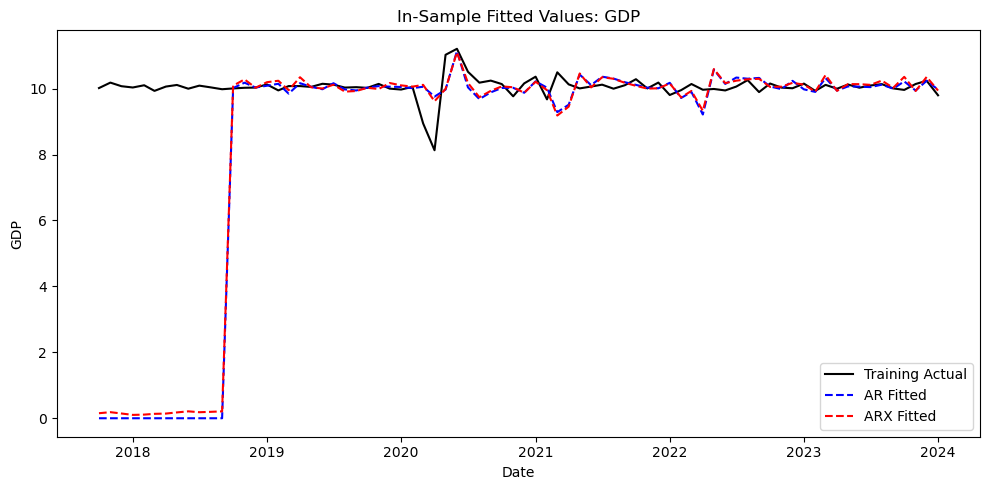

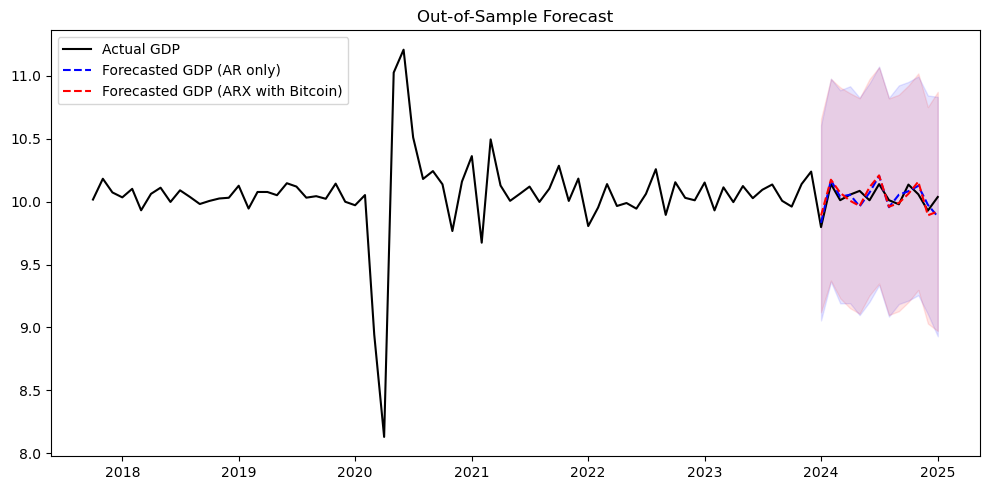

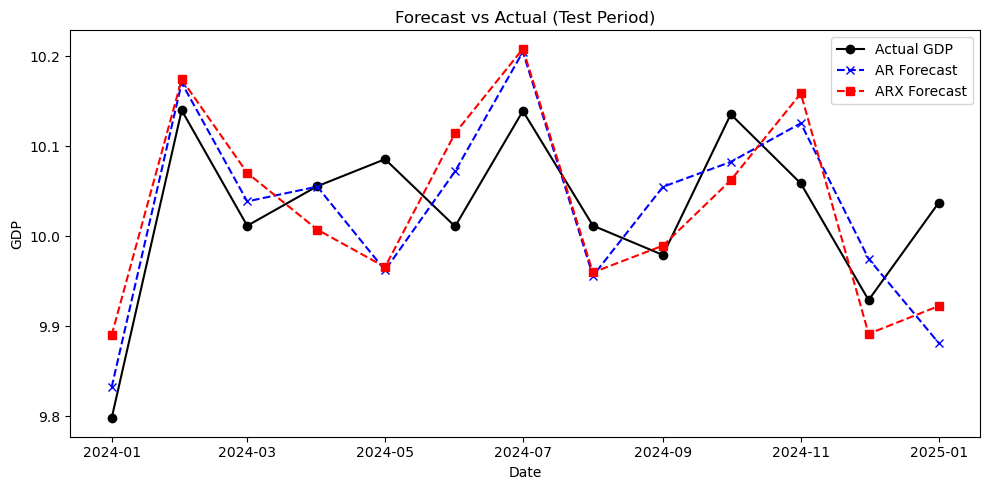

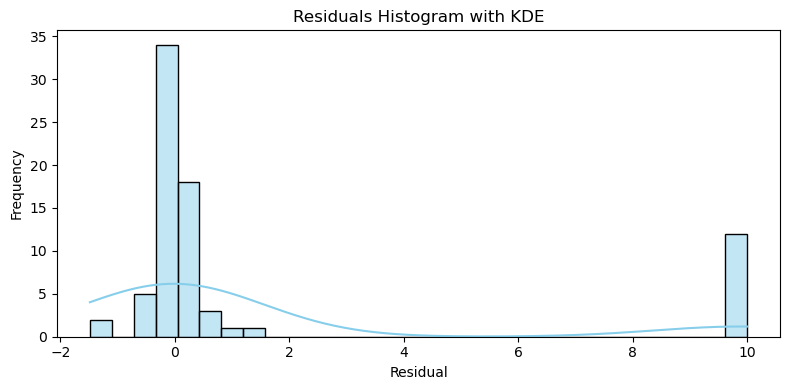

            Residual
Month               
2017-10-01  9.864270
2017-11-01  9.997358
2017-12-01  9.928999
2018-01-01  9.932512
2018-02-01  9.991320
2018-03-01  9.797541
2018-04-01  9.920125
2018-05-01  9.933865
2018-06-01  9.787925
2018-07-01  9.907282
2018-08-01  9.842967
2018-09-01  9.772334
2018-10-01 -0.082810
2018-11-01 -0.254459
2018-12-01  0.005401
2019-01-01 -0.067688
2019-02-01 -0.293310
2019-03-01  0.124333
2019-04-01 -0.267826
2019-05-01  0.010223
2019-06-01  0.143882
2019-07-01  0.000233
2019-08-01  0.122382
2019-09-01  0.116479
2019-10-01 -0.002248
2019-11-01  0.154911
2019-12-01 -0.170389
2020-01-01 -0.127179
2020-02-01 -0.007216
2020-03-01 -1.170960
2020-04-01 -1.485221
2020-05-01  1.034010
2020-06-01  0.106481
2020-07-01  0.340574
2020-08-01  0.441414
2020-09-01  0.310679
2020-10-01  0.070044
2020-11-01 -0.273763
2020-12-01  0.286842
2021-01-01  0.153123
2021-02-01 -0.278481
2021-03-01  1.310983
2021-04-01  0.675855
2021-05-01 -0.452961
2021-06-01  0.026603
2021-07-01 -0

(            MAE      RMSE        R2  MAPE (%)    Order
 Model                                                 
 AR     0.061273  0.072731  0.361508  0.610412  (2,0,0)
 ARX    0.070369  0.077571  0.273695  0.701580  (2,0,0),
 {'Breusch-Pagan p': 0.05128994432347988,
  'Breusch-Godfrey p': 0.08254734819729334,
  'Shapiro p': 2.796175441718535e-14,
  'Anderson stat': 17.68233469845717,
  'Anderson crit': [(15.0, 0.549),
   (10.0, 0.626),
   (5.0, 0.751),
   (2.5, 0.876),
   (1.0, 1.042)],
  'Mean resid': 1.5429692630779859})

In [224]:
run_model(df, 'GDP', 'Bitcoin', plot=True)

In [197]:
assumptions_df

,Macro,Asset,Breusch-Pagan p,Breusch-Godfrey p,Shapiro p,Anderson stat,Mean resid,Anderson 5% crit
0,LFPR,Bitcoin,2.544098e-02,8.378088e-01,4.604846e-15,20.303132,1.568337,0.751
1,LFPR,Litecoin,2.625134e-02,8.252198e-01,4.713125e-15,20.255451,1.556029,0.751
2,LFPR,XRP,1.719781e-01,8.918551e-01,4.601522e-15,20.300403,1.570644,0.751
3,LFPR,Ethereum,3.623515e-03,8.550460e-01,4.718696e-15,20.236982,1.555332,0.751
4,LFPR,Dogecoin,7.442308e-01,9.364476e-01,4.514124e-15,20.342889,1.575018,0.751
5,LFPR,Cardano,2.130466e-02,8.875469e-01,1.665819e-14,18.905335,1.657680,0.749
6,LFPR,Tether,4.752557e-01,8.189524e-01,4.502773e-15,20.360968,1.574898,0.751
7,LFPR,USD Coin,2.926241e-01,8.314273e-01,7.638772e-13,15.006459,1.942171,0.743
8,LFPR,VIX,2.298203e-06,8.507131e-01,4.419881e-15,20.303183,1.602797,0.751
9,LFPR,MOVE,3.005103e-01,8.683819e-01,4.488012e-15,20.361971,1.579782,0.751


## Assumption Testing Results

In [159]:
pd.set_option("display.max_rows", None)  # Show all rows
pd.set_option("display.max_columns", None)  # (optional) Show all columns
pd.set_option("display.width", None)  # Don't wrap columns
pd.set_option("display.max_colwidth", None)  # Don't truncate cell content
display(assumptions_df) 

,Macro,Asset,Breusch-Pagan p,Breusch-Godfrey p,Shapiro p,Anderson stat,Mean resid,Anderson 5% crit
0,LFPR,Bitcoin,2.090908e-04,9.357522e-01,5.093184e-11,3.667762,0.000008,0.751
1,LFPR,Litecoin,2.674970e-03,7.102086e-01,2.605672e-14,8.624639,0.000448,0.751
2,LFPR,XRP,1.684209e-01,9.388852e-01,2.051228e-14,8.757307,-0.000138,0.751
3,LFPR,Ethereum,3.545131e-06,6.845818e-01,3.556436e-14,8.370645,0.000623,0.751
4,LFPR,Dogecoin,9.138133e-01,9.466320e-01,5.354270e-14,8.021754,0.000389,0.751
5,LFPR,Cardano,1.095766e-03,8.527666e-01,5.020292e-10,3.107486,0.000046,0.748
6,LFPR,Tether,9.711416e-01,7.302268e-01,3.606248e-14,8.355229,0.000071,0.750
7,LFPR,USD Coin,9.112712e-01,8.290669e-01,3.809122e-13,8.156905,-0.000066,0.743
8,LFPR,CPI,2.864707e-04,5.318348e-01,2.274035e-13,6.677980,-0.001431,0.751
9,LFPR,r,5.744520e-01,1.734532e-01,9.869124e-04,1.384749,-0.000223,0.751


## All Macro & Crypto Combination

In [151]:
results_list = []
asset = 'Bitcoin'
for macro in macro_list:
        # Run model, plot=False to skip plotting in batch run
        metrics_df, assumptions_df = run_model(df.copy(), macro, asset, plot=False)
        
        # metrics_df is a DataFrame with index Model (AR, ARX) and columns MAE, RMSE, R2, MAPE, Order
        # Add macro and asset columns for clarity
        metrics_df['Macro'] = macro
        metrics_df['Asset'] = asset
        
        results_list.append(metrics_df.reset_index())
# Combine all results into one DataFrame
final_results = pd.concat(results_list, ignore_index=True)

# Rearrange columns to show Model, Macro, Asset, and errors only
final_results = final_results[['Model', 'Macro', 'Asset', 'MAE', 'RMSE', 'R2', 'MAPE (%)']]

# Format float columns for better readability
float_cols = ['MAE', 'RMSE', 'R2']
final_results[float_cols] = final_results[float_cols]

In [152]:
final_results

,Model,Macro,Asset,MAE,RMSE,R2,MAPE (%)
0,AR,LFPR,Bitcoin,0.000970,0.001393,-0.107494,3.884704e+13
1,ARX,LFPR,Bitcoin,0.001303,0.001733,-0.715369,1.959653e+14
2,AR,CPI,Bitcoin,0.001906,0.002209,-1.784968,2.542478e+02
3,ARX,CPI,Bitcoin,0.001327,0.001520,-0.318316,7.294303e+02
4,AR,r,Bitcoin,0.015983,0.026451,-0.575121,3.846154e+01
5,ARX,r,Bitcoin,0.059563,0.070055,-10.048567,1.290245e+16
6,AR,M1,Bitcoin,0.002328,0.002892,-1.462089,9.913263e+01
7,ARX,M1,Bitcoin,0.021705,0.028498,-238.135794,4.678659e+03
8,AR,GDP,Bitcoin,0.002860,0.003373,0.275509,1.136544e+02
9,ARX,GDP,Bitcoin,0.002727,0.003231,0.335016,1.072165e+02


### Combinations Where Adding Asset Data Improves the Model

In [153]:
# Reshape for comparison
df_wide = final_results.pivot_table(
    index=['Macro', 'Asset'],
    columns='Model',
    values=['MAE', 'RMSE', 'R2', 'MAPE (%)']
)

df_wide.columns = ['_'.join(col).strip() for col in df_wide.columns.values]
df_wide.reset_index(inplace=True)

# Define better = lower RMSE, lower MAE, higher R²
df_wide['ARX_better_RMSE'] = df_wide['RMSE_ARX'] < df_wide['RMSE_AR']
df_wide['ARX_better_MAE'] = df_wide['MAE_ARX'] < df_wide['MAE_AR']
df_wide['ARX_better_MAPE'] = df_wide['MAPE (%)_ARX'] < df_wide['MAPE (%)_AR']
df_wide['ARX_better_R2']  = df_wide['R2_ARX']  > df_wide['R2_AR']

# Filter: only combinations where ARX is better by **all** metrics
better_all = df_wide[
    (df_wide['ARX_better_RMSE']) &
    (df_wide['ARX_better_MAE']) &
    (df_wide['ARX_better_MAPE']) &
    (df_wide['ARX_better_R2'])
]

# Display results
if not better_all.empty:
    print("Combinations where ARX (with asset) outperforms AR on all metrics (MAE, RMSE, MAPE, R²):")
    display(better_all[['Macro', 'Asset', 'MAE_AR', 'MAE_ARX', 'RMSE_AR', 'RMSE_ARX', 'MAPE (%)_AR', 'MAPE (%)_ARX', 'R2_AR', 'R2_ARX']])
else:
    print("No combination found where ARX beats AR across MAE, RMSE, and R².")


# Partial wins
print("\n Combinations where ARX has lower MAE:")
display(df_wide[df_wide['ARX_better_MAE']][['Macro', 'Asset', 'MAE_AR', 'MAE_ARX']])

print("\n Combinations where ARX has lower RMSE:")
display(df_wide[df_wide['ARX_better_RMSE']][['Macro', 'Asset', 'RMSE_AR', 'RMSE_ARX']])

print("\n Combinations where ARX has lower MAPE:")
display(df_wide[df_wide['ARX_better_MAPE']][['Macro', 'Asset', 'MAPE (%)_AR', 'MAPE (%)_ARX']])

print("\n Combinations where ARX has higher R²:")
display(df_wide[df_wide['ARX_better_R2']][['Macro', 'Asset', 'R2_AR', 'R2_ARX']])

Combinations where ARX (with asset) outperforms AR on all metrics (MAE, RMSE, MAPE, R²):


,Macro,Asset,MAE_AR,MAE_ARX,RMSE_AR,RMSE_ARX,MAPE (%)_AR,MAPE (%)_ARX,R2_AR,R2_ARX
3,GDP,Bitcoin,0.00286,0.002727,0.003373,0.003231,113.654388,107.21654,0.275509,0.335016



 Combinations where ARX has lower MAE:


,Macro,Asset,MAE_AR,MAE_ARX
0,CC,Bitcoin,0.045138,0.041595
1,CPI,Bitcoin,0.001906,0.001327
3,GDP,Bitcoin,0.002860,0.002727



 Combinations where ARX has lower RMSE:


,Macro,Asset,RMSE_AR,RMSE_ARX
0,CC,Bitcoin,0.062740,0.059455
1,CPI,Bitcoin,0.002209,0.001520
2,EX,Bitcoin,0.008453,0.008172
3,GDP,Bitcoin,0.003373,0.003231
4,IM,Bitcoin,0.028908,0.027630



 Combinations where ARX has lower MAPE:


,Macro,Asset,MAPE (%)_AR,MAPE (%)_ARX
3,GDP,Bitcoin,113.654388,107.21654



 Combinations where ARX has higher R²:


,Macro,Asset,R2_AR,R2_ARX
1,CPI,Bitcoin,-1.784968,-0.318316
2,EX,Bitcoin,-0.298822,-0.213998
3,GDP,Bitcoin,0.275509,0.335016
4,IM,Bitcoin,-0.184342,-0.081915


## Testing Individual Combinations

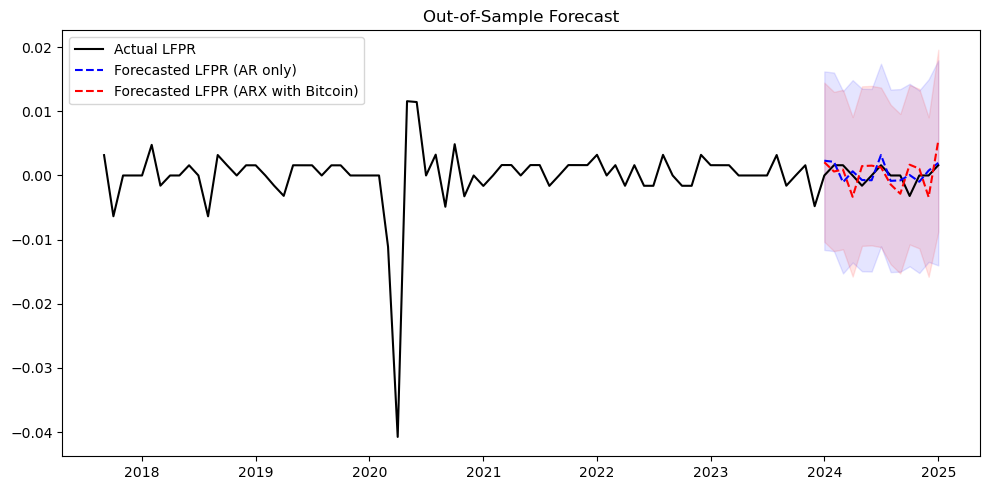

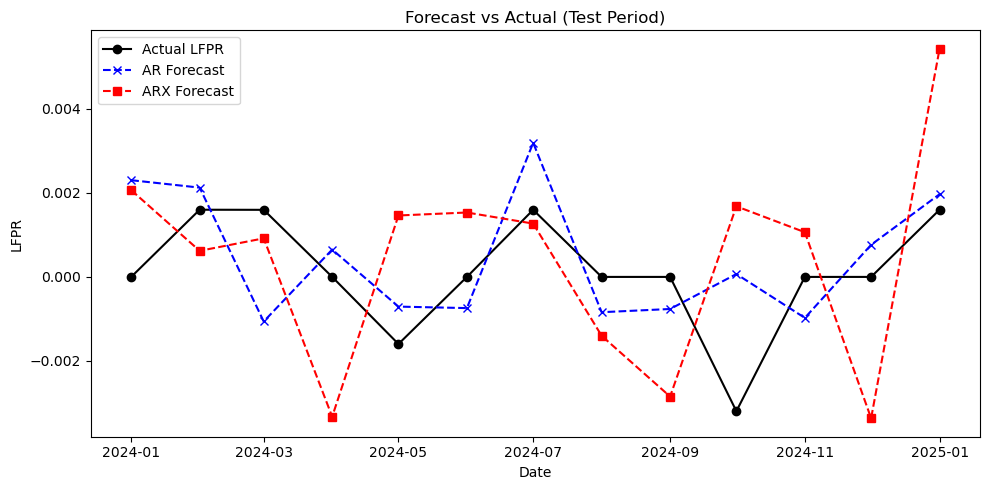

(            MAE      RMSE        R2      MAPE (%)    Order
 Model                                                     
 AR     0.001256  0.001533 -0.341615  2.437361e+14  (2,0,0)
 ARX    0.002257  0.002623 -2.930067  5.403011e+14  (2,0,0),
 {'Breusch-Pagan p': 0.00020909077740281686,
  'Breusch-Godfrey p': 0.9357522349449415,
  'Shapiro p': 7.122645345192965e-05,
  'Anderson stat': 0.8730193001586457,
  'Anderson crit': [(15.0, 0.549),
   (10.0, 0.626),
   (5.0, 0.751),
   (2.5, 0.876),
   (1.0, 1.042)],
  'Mean resid': 7.8786705299221e-05})

In [176]:
macro = 'LFPR'
asset = 'Bitcoin'
run_model(df.copy(), macro, asset, plot=True)

## Finding Optimal Crypto Lag

In [155]:
# def find_optimal_lag(df, macro, asset, max_lag=6, verbose=False):
#     best_lag = None
#     best_improvement = np.inf
#     best_metrics = None

#     results = []

#     for lag in range(0, max_lag + 1):
#         # Temporarily override lag

#         try:
#             metrics = run_model(df, macro, asset, lag)
#             ar = metrics.loc['AR']
#             arx = metrics.loc['ARX']

#             delta_mape = arx['MAPE (%)'] - ar['MAPE (%)']
#             results.append({
#                 'Lag': lag,
#                 'ΔMAPE': delta_mape,
#             })

#             if delta_mape < best_improvement:
#                 best_lag = lag
#                 best_improvement = delta_mape
#                 best_metrics = metrics

#             if verbose:
#                 print(f"Lag {lag}: ΔMAPE = {delta_mape:.2f}")

#         except Exception as e:
#             print(f"Lag {lag}: Failed with error: {e}")
#             continue

#     results_df = pd.DataFrame(results)
#     return best_lag, best_improvement, results_df, best_metrics


In [156]:
# for macro in ar_orders.keys():
#     best_lag, _, _, _ = find_optimal_lag(df, macro, asset="Bitcoin", max_lag=6)
    
#     if best_lag is not None:
#         ar_orders[macro]["VIX_lag"] = best_lag
#     else:
#         ar_orders[macro]["VIX_lag"] = np.nan 